In [1]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import copy
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from framework.layer_node import *
from main.layout import Layout
from main.algorithms import enum_layout_wo_rdt, init_S, coarse_to_fined
from main.head import ASPPHeadNode

from data.nyuv2_dataloader_adashare import NYU_v2
from data.pixel2pixel_loss import NYUCriterions
from data.pixel2pixel_metrics import NYUMetrics

from proto import pytorch_pb2
import google.protobuf.text_format

# Model

In [2]:
class ComputeBlock(nn.Module):
    # Data Structure: A list of CNode as a block to remove non-sequential links
    def __init__(self, compute_nodes):
        super(ComputeBlock, self).__init__() 
        self.compute_nodes = compute_nodes # nn.ModuleList()
        self.parameterized = self.set_param_prop()
        self.task_set = None
        self.layer_idx = None
    
    def forward(self):
        for node in self.compute_nodes:
            node.output = node.forward()
        return node.output
    
    def set_param_prop(self):
        if len(self.compute_nodes) > 1:
            return True
        op = self.compute_nodes[0]
        if isinstance(op, Conv2dNode) or isinstance(op, LinearNode): # to merge Conv2d and BN in the blocks, set BN to be unparam
            return True
        else:
            return False

In [3]:
class MTSeqBackbone(nn.Module):
    def __init__(self, prototxt, layout=None):
        super(MTSeqBackbone, self).__init__()
        self.prototxt = self.parse_prototxt(prototxt)
        self.layout = layout
        self.inputNode = None
        
        # Step 1: Generate computational graph from the backbone model prototxt
        #         self.compute_nodes: the list of CNodes is used to represent the backbone model
        self.compute_nodes = []
        self.generate_computational_graph()
        
        # Step 2: Divide CNodes list into ComputeBlock list
        G = self.create_graph(self.compute_nodes)
        block_list = []
        block_list = self.filter_block_list(self.get_blocks(G, block_list))
        self.basic_blocks = self.remove_unparam_blocks(self.abs_to_real_blocks(block_list, self.compute_nodes))
        
        if self.layout is None: # Indivial Model
            self.basic_blocks = nn.ModuleList(self.basic_blocks)
        else:
            # Step 3: Copy ComputeBlock to construct Multi-Task Model
            #         Copy 1 block for each task set of the layout in each layer
            
            # Sanity Check - The number of blocks?
            if len(self.basic_blocks) != self.layout.B:
                print('Given layout cannot construct multi-task model of the given backbone because of the incompatiable number of blocks.')
                exit()
            
            self.mtl_blocks = []
            for layer_idx in range(self.layout.B):
                basic_block = self.basic_blocks[layer_idx]
                for task_set in self.layout.state[layer_idx]:
                    # set parent block except the first layer
                    if layer_idx != 0:
                        for block in self.mtl_blocks:
                            if block.layer_idx == layer_idx - 1 and task_set.issubset(block.task_set):
                                parent_block = block
                                break
                    else:
                        parent_block = self.inputNode
                    layoutblock = self.block_copy(basic_block, task_set, layer_idx, parent_block)
                    self.mtl_blocks.append(layoutblock)
            self.mtl_blocks = nn.ModuleList(self.mtl_blocks)
            
        gc.collect()
        # Step 4: Initiate Weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, 0.01)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
    
    def forward(self, x): 
        self.inputNode.set_data(x)
        if self.layout is None:
            for block in self.basic_blocks:
                feature = block.forward()
            return feature
        else:
            features = [0] * self.layout.T
            for block in self.mtl_blocks:
                output = block.forward()
                if block.layer_idx == self.layout.B - 1:
                    for task in block.task_set:
                        features[task] = output
            return features
    
    ########## Functions for generating CNodes list ############
    def parse_prototxt(self, prototxt):
        # Function: Parse prototxt by protobuf
        net = pytorch_pb2.NetParameter()
        f = open(prototxt, 'r')
        net = google.protobuf.text_format.Merge(str(f.read()), net)
        f.close()
        return net
    
    def generate_computational_graph(self):
        # Function: Generate computational graph
        #           Iterate through all layers in the prototxt
        for i in range(0, len(self.prototxt.layer)):
            protoLayer = self.prototxt.layer[i]

            # Step 1: Find fatherNodes: CNode whose top name is the bottom name needed
            #         Handle with the 1st layer differently with InputNode
            fatherNodeList = []
            if protoLayer.bottom == ['data'] or protoLayer.bottom == ['blob1']:
                self.inputNode = InputNode(self.prototxt.input_dim[1])
                fatherNodeList.append(self.inputNode)
            else:
                for topName in protoLayer.bottom:
                    fatherNodeList.append(self.find_CNode_by_top_name(topName))
            
            # Step 2: Generate CNode
            CNode = self.generate_CNode(protoLayer, fatherNodeList)
            self.compute_nodes.append(CNode)
            CNode.nodeIdx = i
        return
                    
    def generate_CNode(self, protoLayer, fatherNodeList):
        # Function: Generate CNode for different types of protolayer
        #           e.g., Conv2dNode, BN2dNode, ReLUNode, PoolNode, EltNode, DropoutNode, LinearNode
        nodeType = protoLayer.type

        if nodeType == 'Convolution':
            CNode = Conv2dNode(protoLayer, fatherNodeList)
        elif nodeType == 'BatchNorm':
            CNode = BN2dNode(protoLayer, fatherNodeList)
        elif nodeType == 'ReLU':
            CNode = ReLUNode(protoLayer, fatherNodeList)
        elif nodeType == 'Pooling':
            CNode = PoolNode(protoLayer, fatherNodeList)
        elif nodeType == 'Eltwise':
            CNode = EltNode(protoLayer, fatherNodeList)
        elif nodeType == 'Dropout':
            CNode = DropoutNode(protoLayer, fatherNodeList)
        elif nodeType == 'InnerProduct':
            CNode = LinearNode(protoLayer, fatherNodeList)
        else:
            # Quit and Warning
            sys.exit(nodeType + ': Wrong Layer Type.')
        return CNode
        
    def find_CNode_by_top_name(self, topName):
        # Function: Return the CNode with the required top name
        #           Note to find the latest one
        CNode = None
        for node in self.compute_nodes:
            if node.layerTop == topName:
                CNode = node
        if CNode == None:
            sys.exit('No such CNode with required top name: ' + topName)
        return CNode

    ########## Functions for generating Basic Blocks list ############
    def create_graph(self, node_list):
        # Function: Create graph for NetworkX from the CNodes list
        G = nx.Graph()
        for n in node_list:
            if isinstance(n.fatherNodeList[0], InputNode):
                pass
            else:
                for father in n.fatherNodeList:
                    # Add temporary data node between op nodes
                    data_node = father.nodeIdx + 0.5
                    G.add_edge(father.nodeIdx, data_node, capacity=1)
                    G.add_edge(data_node, n.nodeIdx, capacity=1)
        #             G.add_edge(father.nodeIdx, n.nodeIdx, capacity=1)
        return G

    def get_blocks(self, G, block_list):
        # Function: Divide the graph into a block list
        graph_nodes = set(G.nodes)

        # Exit Case 1: Only have 1 node in the graph
        if len(G.nodes) == 1:
            block_list.append(graph_nodes)
            return

        # Find the minimum cut of the graph
        min_cut = nx.algorithms.flow.minimum_cut(G, min(graph_nodes), max(graph_nodes))

        # Exit Case 2: The size of min_cut > 1
        if min_cut[0] > 1:
            block_list.append(graph_nodes)
            return

        # Divide the graph into 2 subgraphs by the min_cut
        for idx in range(2):
            G_prime = G.subgraph(min_cut[1][idx])
            for e in G_prime.edges():
                nx.set_edge_attributes(G_prime, {e:{'capacity':1}})
            self.get_blocks(G_prime, block_list)
        return block_list

    def filter_block_list(self, block_list):
        # Function: Remove data node
        pure_block_list = []
        for block in block_list:
            new_block = set(filter(lambda x : type(x) == int, block))
            if len(new_block) != 0:
                pure_block_list.append(new_block)
        return pure_block_list

    def abs_to_real_blocks(self, abs_block_list, node_list):
        # Function: Transform abstract block_list to real ComputeBlock list 
        basic_blocks = []
        for block in abs_block_list:
            CNodes = nn.ModuleList() 
            for node_idx in sorted(list(block)):
                CNodes.append(node_list[node_idx])
            basic_blocks.append(ComputeBlock(CNodes))
        return basic_blocks

    def merge_blocks(self, buffer):
        # Function: Merge blocks in the given buffer
        for i in range(1,len(buffer)):
            buffer[0].compute_nodes.extend(buffer[i].compute_nodes)
        buffer[0].parameterized = True
        return 

    def remove_unparam_blocks(self, basic_blocks):
        # Function: Merge unparameterized blocks with its previous parameterized block
        buffer = [] # Blocks to be merged
        for block in basic_blocks:
            if block.parameterized:
                if len(buffer) > 1:
                    self.merge_blocks(buffer)
                buffer = []
                buffer.append(block)
            else:
                buffer.append(block)
        if len(buffer) > 1: # For the last unparam block to be merged
            self.merge_blocks(buffer)
        basic_blocks = [block for block in basic_blocks if block.parameterized]
        return basic_blocks
    
    ########## Functions for generating MTL Blocks list ############
    def block_copy(self, basic_block, task_set, layer_idx, parent_block):
        layoutblock = copy.deepcopy(basic_block)
        layoutblock.task_set = task_set
        layoutblock.layer_idx = layer_idx
        
        old_pointer = id(layoutblock.compute_nodes[0].fatherNodeList[0])
#         print(old_pointer)
        for node in layoutblock.compute_nodes:
            for i in range(len(node.fatherNodeList)):
                if id(node.fatherNodeList[i]) == old_pointer:
#                     print(node)
                    if isinstance(parent_block, InputNode):
                        node.fatherNodeList[i] = self.inputNode
                    else:
                        node.fatherNodeList[i] = parent_block.compute_nodes[-1]
        return layoutblock

In [4]:
class MTSeqModel(nn.Module):
    def __init__(self, prototxt, layout=None, branch=None, fined_B=None, feature_dim=512, cls_num={}):
        super(MTSeqModel, self).__init__()
        
        # Note: Both layout and branch are fined ones (coarse to fined are converted outside the model initialization)
        if layout is not None:
            # Constrcut MTL-Model from layout
            self.layout = layout
        elif layout is None and branch is not None and fined_B is not None:
            # Construct first-order MTL-Model from the branching point and the number of blocks
            if len(cls_num) != 2:
                print('The number of tasks to construct the first-order layouts is not 2.', flush=True)
                exit()
            self.branch = branch
            self.fined_B = fined_B
            self.layout = self.first_order_layout()
        else:
            # Missing params
            print('Missing params for constrcuting multi-task model.', flush=True)
            exit()
        
        print('Construct MTSeqModel from Layout:', flush=True)
        print(self.layout, flush=True)
        self.backbone = MTSeqBackbone(prototxt, self.layout)
        self.heads = nn.ModuleDict()
        for task in cls_num:
            self.heads[task] = ASPPHeadNode(feature_dim, cls_num[task])
        
    def forward(self, x):
        features = self.backbone(x)
        output = {}
        idx = 0
        for task in self.heads:
            output[task] = self.heads[task](features[idx])
            idx += 1
        return output
    
    ############### Helper Function #############
    
    #  Construct layout for two tasks and branch point 
    def first_order_layout(self):
        S = []
        for i in range(self.fined_B):
            if i < self.branch:
                S.append([set([0,1])])
            else:
                S.append([set([0]),set([1])])
        layout =  Layout(2, self.fined_B, S)
        return layout

In [8]:
prototxt = 'models/deeplab_resnet34_adashare.prototxt'
backbone = MTSeqBackbone(prototxt)
fined_B = len(backbone.basic_blocks)

In [9]:
fined_B

17

# Script

In [1]:
# test/use .py directly
import torch
from torch.utils.data import DataLoader

from data.nyuv2_dataloader_adashare import NYU_v2
from data.pixel2pixel_loss import NYUCriterions
from data.pixel2pixel_metrics import NYUMetrics

from main.layout import Layout
from main.algorithms import enum_layout_wo_rdt, init_S, coarse_to_fined
from main.auto_models import MTSeqBackbone, MTSeqModel

In [2]:
# prepare params (number of blocks and feature dim) automatically 
prototxt = 'models/deeplab_resnet34_adashare.prototxt'
# prototxt = 'models/mobilenetv2.prototxt'
with torch.cuda.device(0):
    backbone = MTSeqBackbone(prototxt)
    fined_B = len(backbone.basic_blocks)
    feature_dim = backbone(torch.rand(1,3,224,224)).shape[1]

In [3]:
# coarse to fined mapping

# resnet34
coarse_B = 5
mapping = {0:[0], 1:[1,2,3], 2:[4,5,6,7], 3:[8,9,10,11,12,13], 4:[14,15,16], 5:[17]} 

# mobilenet
# coarse_B = 9
# mapping = {0:[0], 1:[1,2], 2:[3,4,5,6], 3:[7,8,9,10,11], 4:[12,13,14,15,16,17], 5:[18,19,20,21,22], 
#            6:[23,24,25,26,27], 7:[28,29,30], 8:[31], 9:[32]} 

if max(mapping[max(mapping)]) != fined_B:
    print('Wrong mapping for the given backbone model because of inconsistent number of blocks.')
    exit()

In [4]:
# Generate data
dataroot = '/mnt/nfs/work1/huiguan/lijunzhang/policymtl/data/NYUv2/'
tasks = ['segment_semantic','normal','depth_zbuffer']
task_cls_num = {'segment_semantic': 40, 'normal':3, 'depth_zbuffer': 1}

dataset = NYU_v2(dataroot, 'train', crop_h=321, crop_w=321)
trainDataloader = DataLoader(dataset, 16, shuffle=True)

dataset = NYU_v2(dataroot, 'test', crop_h=321, crop_w=321)
valDataloader = DataLoader(dataset, 8, shuffle=True)

criterionDict = {}
metricDict = {}
for task in tasks:
    criterionDict[task] = NYUCriterions(task)
    metricDict[task] = NYUMetrics(task)

In [5]:
# Enum all layouts for given T and B
T = 3 

layout_list = [] 
S0 = init_S(T, coarse_B) # initial state
L = Layout(T, coarse_B, S0) # initial layout
layout_list.append(L)

enum_layout_wo_rdt(L, layout_list)

In [6]:
len(layout_list)

145

In [6]:
# Transform layout to multi-task sequential model 
layout = layout_list[10]
print('Coarse Layout:', flush=True)
print(layout, flush=True)

layout = coarse_to_fined(layout, fined_B, mapping)
print('Fined Layout:', flush=True)
print(layout, flush=True)

model = MTSeqModel(prototxt, layout=layout, feature_dim=feature_dim, cls_num=task_cls_num)

Coarse Layout:
[[{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {2}, {0}], [{1}, {2}, {0}]]
Fined Layout:
[[{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {2}, {0}], [{1}, {2}, {0}], [{1}, {2}, {0}], [{1}, {2}, {0}], [{1}, {2}, {0}], [{1}, {2}, {0}], [{1}, {2}, {0}], [{1}, {2}, {0}], [{1}, {2}, {0}]]
Construct MTSeqModel from Layout:
[[{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {2}, {0}], [{1}, {2}, {0}], [{1}, {2}, {0}], [{1}, {2}, {0}], [{1}, {2}, {0}], [{1}, {2}, {0}], [{1}, {2}, {0}], [{1}, {2}, {0}], [{1}, {2}, {0}]]


In [7]:
model

MTSeqModel(
  (backbone): MTSeqBackbone(
    (inputNode): InputNode()
    (mtl_blocks): ModuleList(
      (0): ComputeBlock(
        (compute_nodes): ModuleList(
          (0): Conv2dNode(
            (basicOp): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          )
          (1): BN2dNode(
            (basicOp): BatchNorm2d(64, eps=9.999999747378752e-06, momentum=0.10000000149011612, affine=True, track_running_stats=True)
          )
          (2): ReLUNode(
            (basicOp): ReLU(inplace=True)
          )
          (3): PoolNode(
            (basicOp): AbstractPool(
              (pool_op): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
            )
          )
        )
      )
      (1): ComputeBlock(
        (compute_nodes): ModuleList(
          (0): Conv2dNode(
            (basicOp): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          )
          (1): BN2dNode(
            (basi

In [9]:
# Give branch point to construct first-order multi-task sequential model 
two_task_cls_num = {'segment_semantic': 40, 'normal':3}

branch = 2
print('Coarse Branch Point:', flush=True)
print(branch, flush=True)

branch = mapping[branch][0]
print('Fined Branch Point:', flush=True)
print(branch, flush=True)

model = MTSeqModel(prototxt, branch=branch, fined_B=fined_B, feature_dim=feature_dim, cls_num=two_task_cls_num)

Coarse Branch Point:
2
Fined Branch Point:
3
Construct MTSeqModel from Layout:
[[{0, 1}], [{0, 1}], [{0, 1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}], [{0}, {1}]]


In [10]:
x = torch.rand(1,3,224,224)
y = model(x)

In [10]:
model

MTSeqModel(
  (backbone): MTSeqBackbone(
    (inputNode): InputNode()
    (mtl_blocks): ModuleList(
      (0): ComputeBlock(
        (compute_nodes): ModuleList(
          (0): Conv2dNode(
            (basicOp): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          )
        )
      )
      (1): ComputeBlock(
        (compute_nodes): ModuleList(
          (0): BN2dNode(
            (basicOp): BatchNorm2d(64, eps=9.999999747378752e-06, momentum=0.10000000149011612, affine=True, track_running_stats=True)
          )
          (1): ReLUNode(
            (basicOp): ReLU(inplace=True)
          )
          (2): PoolNode(
            (basicOp): AbstractPool(
              (pool_op): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
            )
          )
        )
      )
      (2): ComputeBlock(
        (compute_nodes): ModuleList(
          (0): Conv2dNode(
            (basicOp): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

# For Visualize

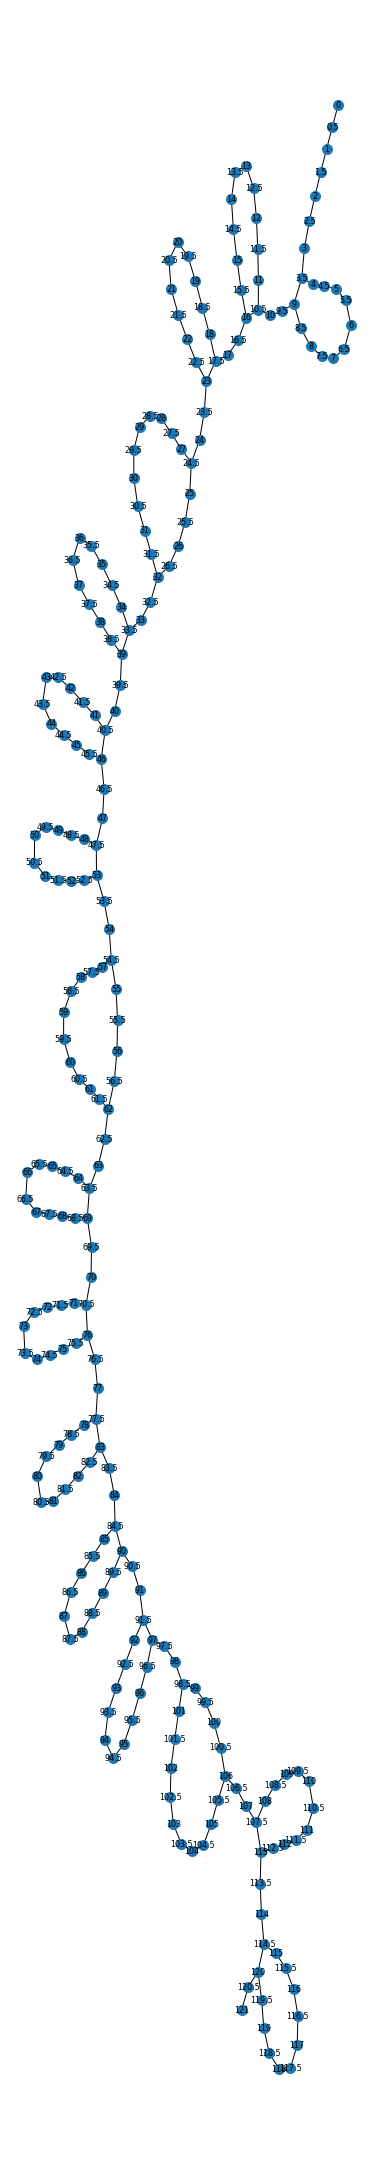

In [7]:
# show graph
plt.figure(figsize=(5,30)) 
nx.draw_kamada_kawai(G, node_size=100, font_size=8, with_labels=True)

In [12]:
import torch.onnx
PATH = "models/mtlmodel_30_auto.onnx"

x = torch.rand(1,3,224,224)
y = model(x)
torch.onnx.export(model,x,PATH)